# Online Bayesian free energies
## For a two-state harmonic system
Denoting the biasing potentials as $\zeta$, the free energy difference in units of $kT$ as $f$, and the samples of the labels as $l$, the basic procedure is the following:

For n = 0:
* **(1)** _Sample $\zeta$ from the posterior_: 
$$ p(\,\zeta_{n+1} \,| \,f_n, \,l_n \,) $$
* **(2)** _Mixture sampling over configuration and labels_:
$$ p(\,l_{n+1},| \,f, \,\zeta_{n+1}\,) $$
* **(3)** _Use `Emcee` to sample from the posterior of the free energy_:
$$ p(\,f_{n+1}\, | \,\zeta_{n+1},\,l_{n+1}) $$
$$ n = n + 1$$

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

from simtk import unit
from harmonic_mixture_sampler import HarmonicSwapper
from free_energy_estimators import BayesianSampler

Initialsing the two harmonic oscillators with different variances:

In [2]:
s = (5.0 , 100.0)
sigma1 = s[0] * unit.angstrom
sigma2 = s[1] * unit.angstrom
true_f =  3*np.log(s[0]/s[1])
print 'True free energy difference = {0:f}'.format( true_f )

True free energy difference = -8.987197


Stating the prior distribution of the free energy difference:

In [3]:
prior_model = 'normal'  # the type of distribution
prior_loc = 0        # the center parameter
prior_spread = 10        # the spread parameter, e.g. standard deviation

Initialising the variables for the algorithm:

In [4]:
n_zeta_resamples = 1    # the number of biasing potentials sampled per iteration
zetas = []               # Where the biasing potentials will be stored
n_moves = []            # the number of label samples taken
n_success = []          # the number of samples in the second state
median = []
lowerq = []
upperq = []

n_mixture_attempts = 8000     # The number of labelled mixture samples of the harmonic oscillator
mixture_save_freq = 200        # The frequency that the state lables will be save. Preferable a factor of n_mixture_attempts 
print 'The number of label samples per zeta value = {0:f}'.format(1.0 * n_mixture_attempts / mixture_save_freq)
openmm = False                 # Whether to use openmm to sample the harmonic oscillator

# The initial samples from the prior
f_samples = np.random.normal(loc = prior_loc, scale = prior_spread, size = n_zeta_resamples)

The number of label samples per zeta value = 40.000000


## The actual sampling

In [5]:
#print 'True free energy difference = {0:f}'.format( true_f )    
for i in range(50):
    # Step (1): Samples zetas:
    new_zetas = []
    for f in f_samples:
        z = np.random.logistic(loc = f)
        zetas.append(z)
        new_zetas.append(z)

    # Step (2): Mixture sampling over configurations and labels
    for i in range(len(new_zetas)):
        swapper = HarmonicSwapper(sigma1, sigma2, zeta = [0.0,new_zetas[i]])
        swapper.mixture_sample(niterations = n_mixture_attempts, openmm = openmm, save_freq = mixture_save_freq )
        n_success.append( 1.0*swapper.state_counter )

    #Step (3): Bayesian estimation of free energies from binomial data
    sampler = BayesianSampler(zetas = np.array(zetas), nsuccesses = np.array(n_success), nsamples = swapper.nmoves)
    chain = sampler.sample_posterior()
    flat_samples = chain[:, 50:, :].reshape((-1, 1))
    # Generate new f samples to generate new zetas
    f_samples  = np.random.choice(flat_samples[:,0], size = n_zeta_resamples)
    
    # Data saving:
    #print 'posterior mean = {0:f} and standard deviation = {1:f}'.format(flat_samples.mean(),flat_samples.std())
    median.append( np.percentile(flat_samples,50) )
    lowerq.append( np.percentile(flat_samples,97.5) )
    upperq.append( np.percentile(flat_samples,2.5) )

## Ploting
#### The free energy estimate and error at each iteration

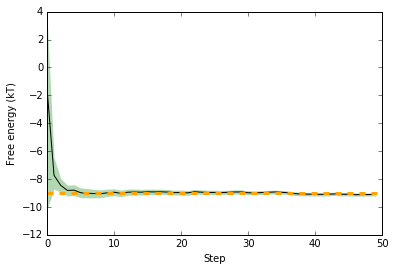

In [6]:
x = range(len(median))
plt.clf()
plt.plot(x,median,color='k')
plt.axhline(y = true_f,color='orange',ls='--', lw=3)
plt.fill_between(x,lowerq,upperq, facecolor='green',linewidth=0,alpha=0.3,interpolate=True)
plt.xlabel('Step')
plt.ylabel('Free energy (kT)')
plt.show()

It seems the bigger the difference in free energy, the worse the estimator and error estimate. This may be due to the fact that the mixture samples are no longer independent. It may be possible to have a diagnostic for this, for instance, low acceptance rates between swaps.

#### The proportion of samples in state 1 for each $\zeta$
The colour of the points go from green to yellow as the algorithim progesses.

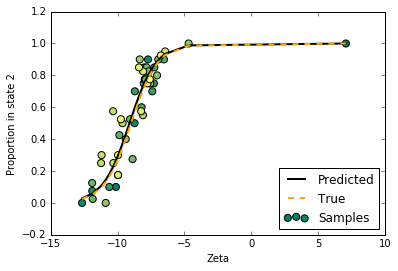

In [7]:
z_sorted = np.sort(zetas)
true_fraction = np.sort( sampler.logistic(true_f) )
predicted = np.sort( sampler.logistic(median[-1]) )
predicted_lower = np.sort( sampler.logistic(lowerq[-1]) )
predicted_upper = np.sort( sampler.logistic(upperq[-1]) )

color_grad =  plt.cm.summer(np.linspace(0,1,len(zetas)))
fraction = np.array(n_success) / float(swapper.nmoves)
#color_fraction = float((i + 1)/len(zetas)) 
plt.scatter(zetas,fraction, color = color_grad, s = 50, edgecolors='k')
plt.fill_between(z_sorted, predicted_lower, predicted_upper, facecolor='grey',linewidth=0,alpha=0.3,interpolate=True)
plt.plot(z_sorted, predicted, color = 'k', lw = 2)
plt.plot(z_sorted,true_fraction, color = 'orange', lw = 2, ls = '--')

plt.legend(('Predicted','True','Samples'),loc = 4)
plt.xlabel('Zeta')
plt.ylabel('Proportion in state 2')
plt.show()